In [1]:
"""
Using a set of various models to estimate the delivery delay amount. I have shown various metrics here but the quantile loss or the mean pinball loss might be
better because it is more important for us to deliver a product early rather than late. We can also use an ensemble of the best models.
"""

import time
import numpy as np
from tobit import *
import pandas as pd
from math import sqrt
from sklearn import tree
import statsmodels as sm
from sklearn.svm import LinearSVR
from lifelines import CoxPHFitter
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score
import statsmodels.formula.api as smf
from catboost import CatBoostRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline , make_pipeline
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestClassifier , HistGradientBoostingRegressor , GradientBoostingRegressor
from sklearn.metrics import mean_squared_error , mean_absolute_error , mean_absolute_percentage_error , mean_pinball_loss
from sklearn.linear_model import LinearRegression , LogisticRegression , BayesianRidge , SGDRegressor , ElasticNet , PoissonRegressor

In [2]:
ood_p = pd.read_csv('delivery_dely_prediction.csv')

In [3]:
ood = pd.read_csv('delivery_dely_prediction_target.csv')

In [4]:
"""
We use sin and cos to map interval features such as hour of day and day of week to values which would better represent their periodic nature.
Also dividing the data into a train and test set and standardizing numerical data such as the weight and length of products.
"""


numerical_columns = ['order_purchase_year', 'payment_value', 'item_count', 'price_max', 'price_sum', 'freight_value_max', 'freight_value_sum', 'product_weight_g_max', 'product_weight_g_sum', 'distance_max', 'distance_sum', 'product_max_cm_max', 'product_max_cm_sum', 'product_volume_cm_max', 'product_volume_cm_sum']
nominal_columns = ['order_purchase_month', 'order_purchase_day', 'order_purchase_dayofweek', 'order_purchase_hour']

ood_p = ood.drop(['order_delivered_customer_date_delay'], axis = 1)
ood_p['order_purchase_month_sin'] = np.sin(ood_p['order_purchase_month'] / 12 * 2 * np.pi)
ood_p['order_purchase_month_cos'] = np.cos(ood_p['order_purchase_month'] / 12 * 2 * np.pi)
ood_p['order_purchase_day_sin'] = np.sin(ood_p['order_purchase_day'] / 31 * 2 * np.pi)
ood_p['order_purchase_day_cos'] = np.cos(ood_p['order_purchase_day'] / 31 * 2 * np.pi)
ood_p['order_purchase_dayofweek_sin'] = np.sin(ood_p['order_purchase_dayofweek'] / 7 * 2 * np.pi)
ood_p['order_purchase_dayofweek_cos'] = np.cos(ood_p['order_purchase_dayofweek'] / 7 * 2 * np.pi)
ood_p['order_purchase_hour_sin'] = np.sin(ood_p['order_purchase_hour'] / 24 * 2 * np.pi)
ood_p['order_purchase_hour_cos'] = np.cos(ood_p['order_purchase_hour'] / 24 * 2 * np.pi)
ood_p = ood_p.drop(nominal_columns, axis = 1)

train_data, test_data, train_labels, test_labels = train_test_split(ood_p, ood['order_delivered_customer_date_delay'], test_size = 0.2, random_state = 42)

In [5]:
pipeline = ColumnTransformer([
    ("Numerical", StandardScaler(), numerical_columns),
    ], remainder = 'passthrough',)

train_data = pipeline.fit_transform(train_data)
test_data = pipeline.transform(test_data)

In [15]:
models = [
    ['LinearRegression', LinearRegression()],
    ['Decision Tree',tree.DecisionTreeRegressor()],
    ['BayesianRidge', BayesianRidge()],
    ['SGD', SGDRegressor()],
    ['LinearSVR', LinearSVR()],
    ['HistGradientBoosting', HistGradientBoostingRegressor()],
    ['GradientBoosting', GradientBoostingRegressor()],
    ['LGBM', LGBMRegressor()],
    ['XGB', XGBRegressor()],
    ['CatBoost', CatBoostRegressor(logging_level = 'Silent')],
    ['Elastic Net Regression',ElasticNet(alpha=1.0, l1_ratio=0.5)],
    ['PLS Regression', PLSRegression(n_components=2)],
    ['Poisson Regression', PoissonRegressor() ],
         ]

In [7]:
######              Remaining models
# ['Negative Binomial Regression', sm.GLM(family=sm.families.Poisson())],
# ['OLS regression model', smf.ols()],
# ['Quasi Poisson Regression',],
# ['Principal Components Regression (PCR)',
# ['Ordinal Regression', OrderedModel()],
#     ['Cox Regression', CoxPHFitter()],
#     ['Tobit Regression' , TobitModel()],
#     ['Logistic Regression',LogisticRegression()],
#     ['Support Vector Regression', make_pipeline(StandardScaler(), LinearSVR(C=1.0, epsilon=0.2))],

In [16]:
model_data = []
for name, curr_model in models :
    curr_model_data = {}
    curr_model.random_state = 42
    curr_model_data["Name"] = name
    start = time.time()
    curr_model.fit(train_data, train_labels)
    end = time.time()
    train_pred = curr_model.predict(train_data)
    test_pred = curr_model.predict(test_data)
    curr_model_data["Train_Time"] = end - start
    curr_model_data["Train_MAE"] = mean_absolute_error(train_labels, train_pred)
    curr_model_data["Test_MAE"] = mean_absolute_error(test_labels, test_pred)
    curr_model_data["Train_MSE"] = mean_squared_error(train_labels, train_pred)
    curr_model_data["Test_MSE"] = mean_squared_error(test_labels, test_pred)
    curr_model_data["Train_RMSE"] = sqrt(mean_squared_error(train_labels, train_pred))
    curr_model_data["Test_RMSE"] = sqrt(mean_squared_error(test_labels, test_pred))
    curr_model_data["Train_MAPE"] = mean_absolute_percentage_error(train_labels, train_pred)
    curr_model_data["Test_MAPE"] = mean_absolute_percentage_error(test_labels, test_pred)
    curr_model_data["Train_R2"] = r2_score(train_labels, train_pred)
    curr_model_data["Test_R2"] = r2_score(test_labels, test_pred)
    curr_model_data["Train_Quantile_Loss"] = mean_pinball_loss(train_labels, train_pred, alpha = 0.75)
    curr_model_data["Test_Quantile_Loss"] = mean_pinball_loss(test_labels, test_pred, alpha = 0.75)
    model_data.append(curr_model_data)

# We evaluate here that decision tree regresor is working perfectly as it is one of famous regressor

In [17]:
model_scores = pd.DataFrame(model_data)
model_scores

,Name,Train_Time,Train_MAE,Test_MAE,Train_MSE,Test_MSE,Train_RMSE,Test_RMSE,Train_MAPE,Test_MAPE,Train_R2,Test_R2,Train_Quantile_Loss,Test_Quantile_Loss
0,LinearRegression,0.157489,5.299546,5.169724,71.947158,63.565616,8.482167,7.972805,0.586064,0.587254,0.224786,0.249908,2.649773,2.533164
1,Decision Tree,3.550155,0.000864,6.443185,0.004839,129.229414,0.069566,11.367912,0.000086,0.633453,0.999948,-0.524943,0.000432,3.082991
2,BayesianRidge,0.298067,5.300961,5.169874,71.969256,63.574664,8.483470,7.973372,0.586683,0.587641,0.224548,0.249801,2.650481,2.533275
3,SGD,1.113313,5.300324,5.167914,72.162390,63.693904,8.494845,7.980846,0.590437,0.591759,0.222467,0.248394,2.666939,2.549057
4,LinearSVR,7.181931,5.038124,4.886721,75.988815,66.600721,8.717156,8.160927,0.462306,0.461980,0.181238,0.214093,2.980168,2.852894
5,HistGradientBoosting,3.839197,4.725861,4.749454,59.227280,56.533431,7.695926,7.518872,0.489813,0.501856,0.361840,0.332890,2.361568,2.319540
6,GradientBoosting,45.152404,4.996841,4.909357,65.857757,59.258502,8.115279,7.697954,0.519750,0.522995,0.290398,0.300733,2.498421,2.402131
7,LGBM,0.644892,4.720926,4.739643,59.170338,56.329347,7.692226,7.505288,0.488033,0.500073,0.362453,0.335298,2.360463,2.317593
8,XGB,6.576682,4.339092,4.755195,46.625956,57.580786,6.828320,7.588200,0.447202,0.494325,0.497616,0.320531,2.169983,2.317702
9,CatBoost,9.078988,4.527619,4.695443,52.546704,55.809537,7.248911,7.470578,0.463326,0.489651,0.433821,0.341432,2.263983,2.292098


<AxesSubplot:xlabel='Name'>

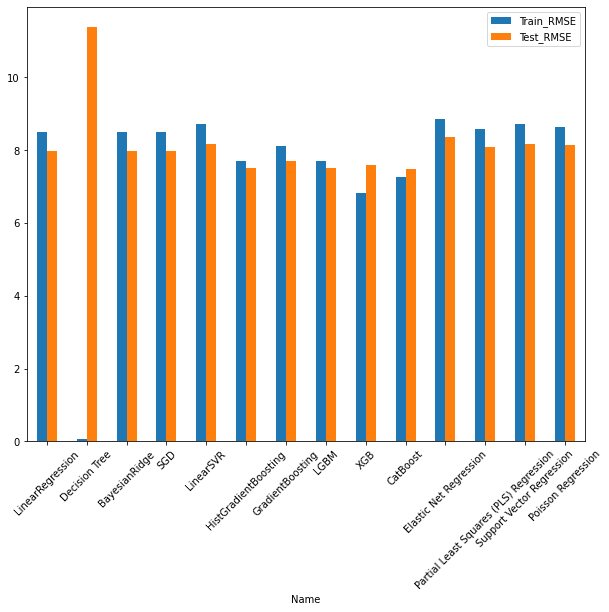

In [10]:
model_scores.plot(x = 'Name', y = ['Train_RMSE', 'Test_RMSE'], kind = 'bar', figsize = (10, 8), rot = 45)

In [11]:
# """
# Optimizing the hyperparameters of the model.
# """
# from flaml import AutoML

# automl = AutoML()
# automl_settings = {
#     'time_budget': 180,
#     'task': 'regression',
#     'estimator_list': ['lgbm'],
#     'metric': 'rmse',
#     'verbose': 0,
# }

# automl.fit(X_train = train_data, y_train = train_labels, **automl_settings)

# print('Best hyperparmeter config:', automl.best_config)

In [12]:
# print('Optimized model train error: ' + str(np.sqrt(mean_squared_error(automl.predict(train_data), train_labels))))

In [13]:
# print('Optimized model test error: ' + str(np.sqrt(mean_squared_error(automl.predict(test_data), test_labels))))

In [14]:
# """
# Most important features for the model.
# """

# feat_importances = pd.Series(automl.model.estimator.feature_importances_, index = ood_p.columns)
# feat_importances.nlargest(10).plot(kind = 'barh').invert_yaxis()